In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

import wrangle as w

In [2]:
df = w.wrangle_wildlife_strike_df()

cached csv file found and read


In [3]:
df.head()

,time_of_day,airport_id,airport,runway,state,opid,operator,aircraft,ac_class,ac_mass,type_eng,num_engs,phase_of_flight,precipitation,damage_level,species_id,species,size_of_species,nr_injuries,nr_fatalities
date,,,,,,,,,,,,,,,,,,,,
1990-01-02,Unknown,KJFK,JOHN F KENNEDY INTL,31L,NY,FDX,FEDEX EXPRESS,DC-10,A,4,D,3,Departure,Unknown,N,UNKB,Unknown bird,Unknown,0,0
1990-01-02,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,Z,0,Z,-1,Unknown,Unknown,N,R1101,Barn owl,Small,0,0
1990-01-04,Unknown,PHLI,LIHUE ARPT,99,HI,HAL,HAWAIIAN AIR,DC-9,A,4,D,2,Landing Roll,Unknown,N,ZY1,Munias,Small,0,0
1990-01-05,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,Z,0,Z,-1,Unknown,Unknown,N,N5122,Pacific golden-plover,Small,0,0
1990-01-05,Unknown,PHLI,LIHUE ARPT,99,HI,UNK,UNKNOWN,UNKNOWN,Z,0,Z,-1,Unknown,Unknown,N,ZY1,Munias,Small,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 279942 entries, 1990-01-02 to 2023-05-17
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   time_of_day      279942 non-null  object
 1   airport_id       279942 non-null  object
 2   airport          279942 non-null  object
 3   runway           279942 non-null  object
 4   state            279942 non-null  object
 5   opid             279942 non-null  object
 6   operator         279942 non-null  object
 7   aircraft         279942 non-null  object
 8   ac_class         279942 non-null  object
 9   ac_mass          279942 non-null  int64 
 10  type_eng         279942 non-null  object
 11  num_engs         279942 non-null  int64 
 12  phase_of_flight  279942 non-null  object
 13  precipitation    279942 non-null  object
 14  damage_level     279942 non-null  object
 15  species_id       279942 non-null  object
 16  species          279942 non-null  object

In [5]:
for col in df.columns:
    print(f'Value Counts for ----- {col} -----')
    print(df[col].value_counts())
    print(f'Num of nulls: {df[col].isnull().sum()}')
    print(f'Num of NON-nulls: {df[col].notnull().sum()}')
    print()

Value Counts for ----- time_of_day -----
Unknown    117672
Day         99664
Night       49430
Dusk         7286
Dawn         5890
Name: time_of_day, dtype: int64
Num of nulls: 0
Num of NON-nulls: 279942

Value Counts for ----- airport_id -----
ZZZZ    34302
KDEN     9260
KDFW     7527
KORD     6065
KJFK     5882
        ...  
T40         1
LIRP        1
KTLR        1
OI65        1
PALP        1
Name: airport_id, Length: 2591, dtype: int64
Num of nulls: 0
Num of NON-nulls: 279942

Value Counts for ----- airport -----
UNKNOWN                        34302
DENVER INTL AIRPORT             9260
DALLAS/FORT WORTH INTL ARPT     7527
CHICAGO O'HARE INTL ARPT        6065
JOHN F KENNEDY INTL             5882
                               ...  
HOUSTON GULF ARPT                  1
GALILEO GALILEI ARPT               1
MCGEHEE CATFISH REST               1
MEFFORD FIELD ARPT                 1
ALPINE AIRSTRIP                    1
Name: airport, Length: 2591, dtype: int64
Num of nulls: 0
Num of NON-n

In [6]:
# I'll keep these 20 columns for exploration. For moving forward to modeling, I intend to drop it
# to 9 columns (cao 20230606 14:00, pre-exploring). We will now explore and see what we find.

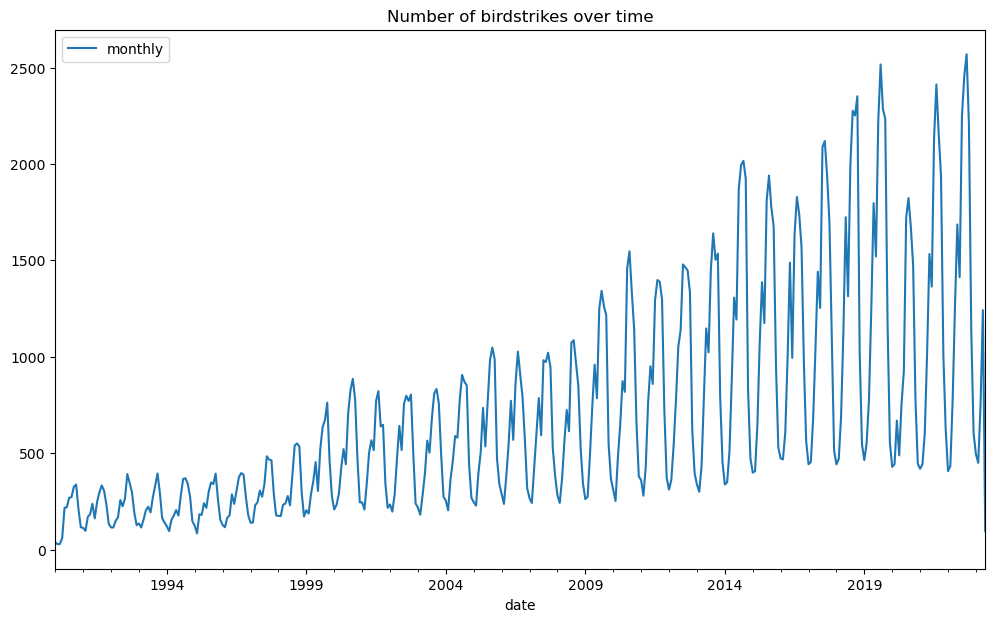

In [7]:
# univariate analysis - plotting number of birdstrikes
plt.figure(figsize=(12,7))
# df.resample('D').aircraft.count().plot(label='daily')
df.resample('M').aircraft.count().plot(label='monthly')
# df.resample('Y').aircraft.count().plot(label='yearly')
plt.legend()
plt.title('Number of birdstrikes over time')
plt.show()

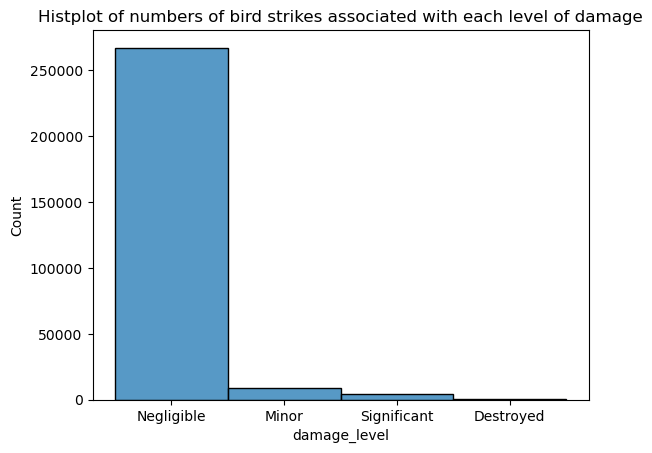

In [8]:
sns.histplot(data=df.damage_level)
plt.title('Histplot of numbers of bird strikes associated with each level of damage')
plt.xticks(ticks=['N','M','S','D'], labels=['Negligible', 'Minor', 'Significant', 'Destroyed'])
plt.show()

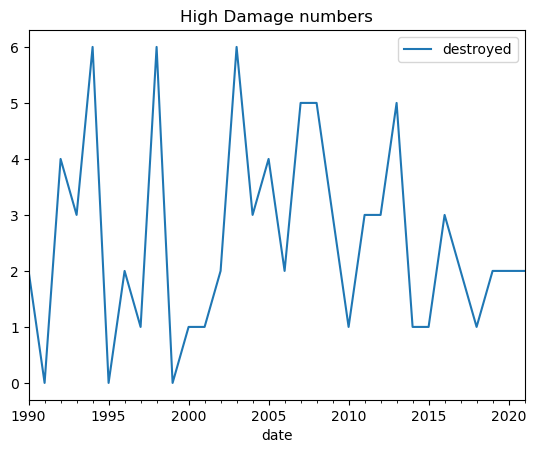

In [9]:
df[df.damage_level.str.contains('D')].resample('Y').aircraft.count().plot(label='destroyed')
# df[df.damage_level.str.contains('S')].resample('Y').aircraft.count().plot(label='significant')
plt.legend()
plt.title('High Damage numbers')
plt.show()

In [10]:
# split data for exploration
train, validate, test = w.split_function(df, 'damage_level')

Prepared df: (279942, 20)

Train: (167964, 20)
Validate: (55989, 20)
Test: (55989, 20)


# Explore - Hypothesize/Visualize/Analyze (w/ stats)/Summarize

## Visualize - First, I'm going to look at all the categorical variables and all the numeric variables and visualize them just to see.

In [11]:
# separate columns by categorical and numeric
col_cats = []
num_cats = []

for col in train.columns:
    if train[col].dtype == 'O':
        col_cats.append(col)
    else:
        if len(train[col].unique()) < 4: # make anything with less than 4 unique values a categorical variable
            col_cats.append(col)
        else:
            num_cats.append(col)
print("col_cats = ")
print(col_cats)
print("num_cats")
print(num_cats)

col_cats = 
['time_of_day', 'airport_id', 'airport', 'runway', 'state', 'opid', 'operator', 'aircraft', 'ac_class', 'type_eng', 'phase_of_flight', 'precipitation', 'damage_level', 'species_id', 'species', 'size_of_species']
num_cats
['ac_mass', 'num_engs', 'nr_injuries', 'nr_fatalities']


### categorical variables

TIME_OF_DAY
Unknown    70423
Day        59958
Night      29724
Dusk        4328
Dawn        3531
Name: time_of_day, dtype: int64
Unknown    0.419274
Day        0.356969
Night      0.176966
Dusk       0.025767
Dawn       0.021022
Name: time_of_day, dtype: float64


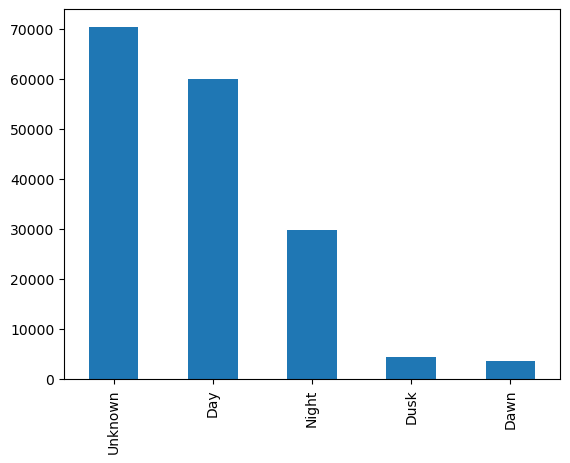


AIRPORT_ID
ZZZZ    20584
KDEN     5607
KDFW     4501
KORD     3658
KJFK     3510
        ...  
KCNI        1
KHIG        1
KHUA        1
KMHL        1
7V2         1
Name: airport_id, Length: 2178, dtype: int64
ZZZZ    0.122550
KDEN    0.033382
KDFW    0.026797
KORD    0.021778
KJFK    0.020897
          ...   
KCNI    0.000006
KHIG    0.000006
KHUA    0.000006
KMHL    0.000006
7V2     0.000006
Name: airport_id, Length: 2178, dtype: float64


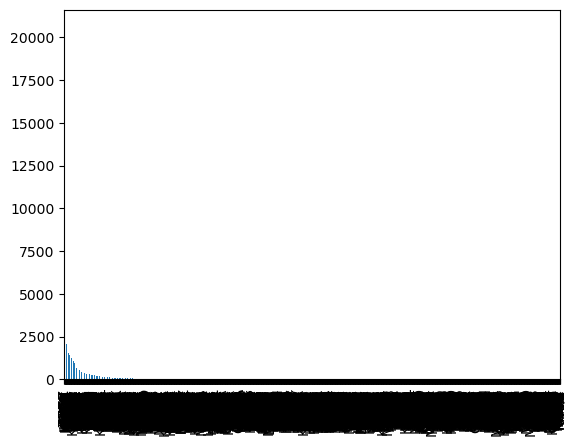


AIRPORT
UNKNOWN                        20584
DENVER INTL AIRPORT             5607
DALLAS/FORT WORTH INTL ARPT     4501
CHICAGO O'HARE INTL ARPT        3658
JOHN F KENNEDY INTL             3510
                               ...  
DEFIANCE MEMORIAL AIRPORT          1
CUT BANK MUNICIPAL ARPT            1
KLEBERG COUNTY ARPT                1
VOLK FIELD ARPT                    1
NORTH FORK VALLEY                  1
Name: airport, Length: 2177, dtype: int64
UNKNOWN                        0.122550
DENVER INTL AIRPORT            0.033382
DALLAS/FORT WORTH INTL ARPT    0.026797
CHICAGO O'HARE INTL ARPT       0.021778
JOHN F KENNEDY INTL            0.020897
                                 ...   
DEFIANCE MEMORIAL AIRPORT      0.000006
CUT BANK MUNICIPAL ARPT        0.000006
KLEBERG COUNTY ARPT            0.000006
VOLK FIELD ARPT                0.000006
NORTH FORK VALLEY              0.000006
Name: airport, Length: 2177, dtype: float64


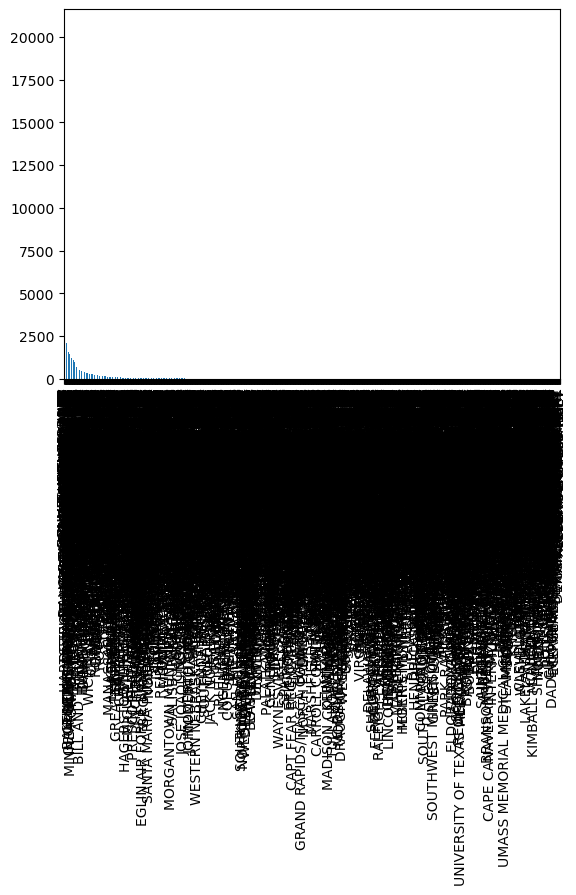


RUNWAY
99        40785
27         2345
17R        2295
22L        2239
23         2121
          ...  
8R            1
21/20R        1
4/J           1
25 R          1
 10/28        1
Name: runway, Length: 914, dtype: int64
99        0.242820
27        0.013961
17R       0.013664
22L       0.013330
23        0.012628
            ...   
8R        0.000006
21/20R    0.000006
4/J       0.000006
25 R      0.000006
 10/28    0.000006
Name: runway, Length: 914, dtype: float64


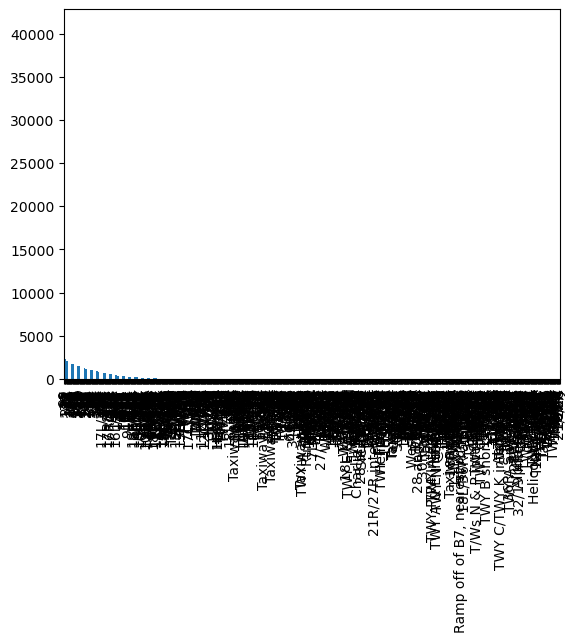


STATE
ZZ    20625
TX    14395
FL    11980
CA    11903
NY     8315
      ...  
AB       27
MB       12
NS        4
SK        2
NL        1
Name: state, Length: 64, dtype: int64
ZZ    0.122794
TX    0.085703
FL    0.071325
CA    0.070866
NY    0.049505
        ...   
AB    0.000161
MB    0.000071
NS    0.000024
SK    0.000012
NL    0.000006
Name: state, Length: 64, dtype: float64


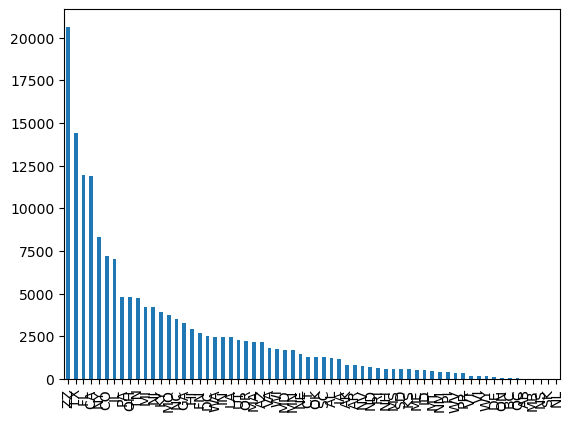


OPID
UNK    46824
BUS    14175
SWA    13944
AAL    11847
UAL    10338
       ...  
HTC        1
AEK        1
RKA        1
ETH        1
RLR        1
Name: opid, Length: 549, dtype: int64
UNK    0.278774
BUS    0.084393
SWA    0.083018
AAL    0.070533
UAL    0.061549
         ...   
HTC    0.000006
AEK    0.000006
RKA    0.000006
ETH    0.000006
RLR    0.000006
Name: opid, Length: 549, dtype: float64


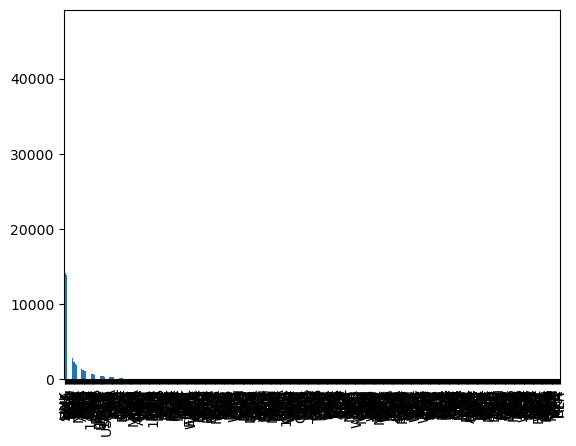


OPERATOR
UNKNOWN                     46824
BUSINESS                    14175
SOUTHWEST AIRLINES          13944
AMERICAN AIRLINES           11847
UNITED AIRLINES             10338
                            ...  
EDELWEISS AIR                   1
TAP AIR PORTUGAL                1
CAPITAL CITY AIR CARRIER        1
CHARTRIGHT AIR                  1
MALEV                           1
Name: operator, Length: 543, dtype: int64
UNKNOWN                     0.278774
BUSINESS                    0.084393
SOUTHWEST AIRLINES          0.083018
AMERICAN AIRLINES           0.070533
UNITED AIRLINES             0.061549
                              ...   
EDELWEISS AIR               0.000006
TAP AIR PORTUGAL            0.000006
CAPITAL CITY AIR CARRIER    0.000006
CHARTRIGHT AIR              0.000006
MALEV                       0.000006
Name: operator, Length: 543, dtype: float64


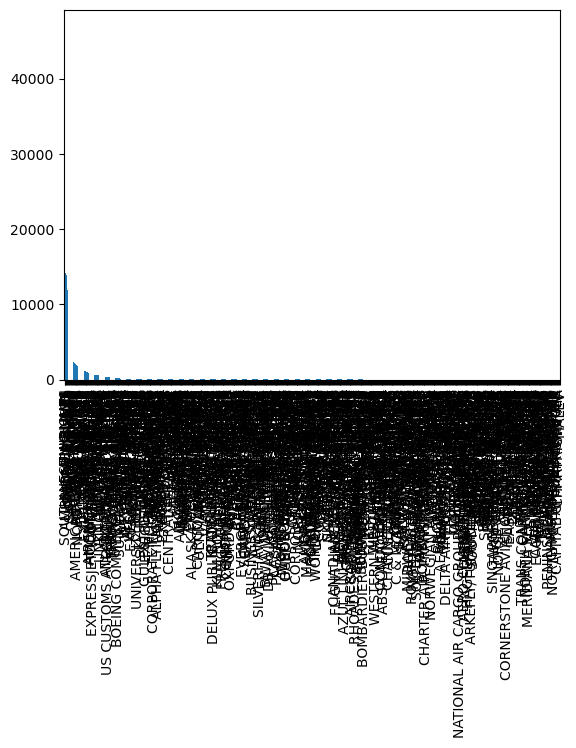


AIRCRAFT
UNKNOWN              46992
B-737-700             8426
A-320                 8010
B-737-800             6248
CRJ100/200            5676
                     ...  
PA-36-375                1
H-60                     1
BELL HH-IH               1
MORAVAN ZLIN 242L        1
AERO AT-4                1
Name: aircraft, Length: 551, dtype: int64
UNKNOWN              0.279774
B-737-700            0.050166
A-320                0.047689
B-737-800            0.037198
CRJ100/200           0.033793
                       ...   
PA-36-375            0.000006
H-60                 0.000006
BELL HH-IH           0.000006
MORAVAN ZLIN 242L    0.000006
AERO AT-4            0.000006
Name: aircraft, Length: 551, dtype: float64


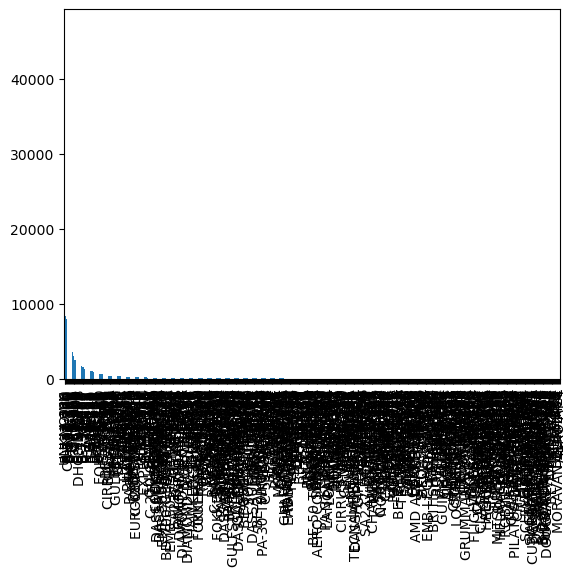


AC_CLASS
A      118141
Z       47201
B        2613
C           4
J           3
Y           2
Name: ac_class, dtype: int64
A      0.703371
Z      0.281019
B      0.015557
C      0.000024
J      0.000018
Y      0.000012
Name: ac_class, dtype: float64


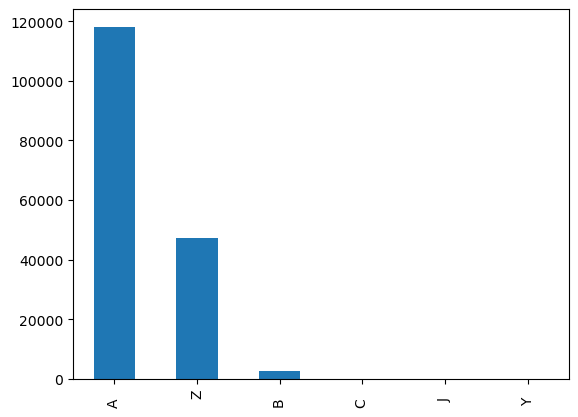


TYPE_ENG
D    100978
Z     47711
C      8818
A      7846
F      2429
B       177
E         3
Y         2
Name: type_eng, dtype: int64
D    0.601188
Z    0.284055
C    0.052499
A    0.046712
F    0.014461
B    0.001054
E    0.000018
Y    0.000012
Name: type_eng, dtype: float64


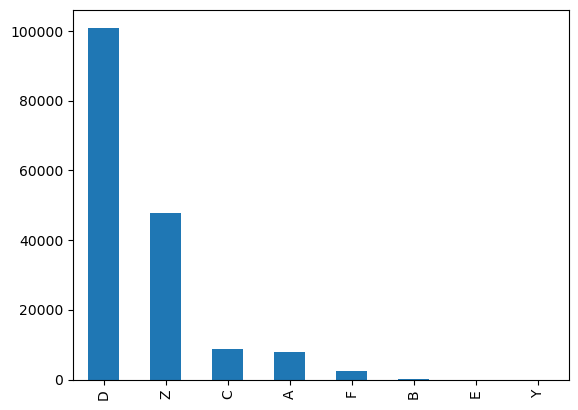


PHASE_OF_FLIGHT
Unknown         63979
Approach        43923
Landing Roll    18815
Take-off Run    17647
Climb           15833
En Route         3205
Departure        1599
Descent          1378
Local             670
Arrival           448
Taxi              403
Parked             64
Name: phase_of_flight, dtype: int64
Unknown         0.380909
Approach        0.261502
Landing Roll    0.112018
Take-off Run    0.105064
Climb           0.094264
En Route        0.019081
Departure       0.009520
Descent         0.008204
Local           0.003989
Arrival         0.002667
Taxi            0.002399
Parked          0.000381
Name: phase_of_flight, dtype: float64


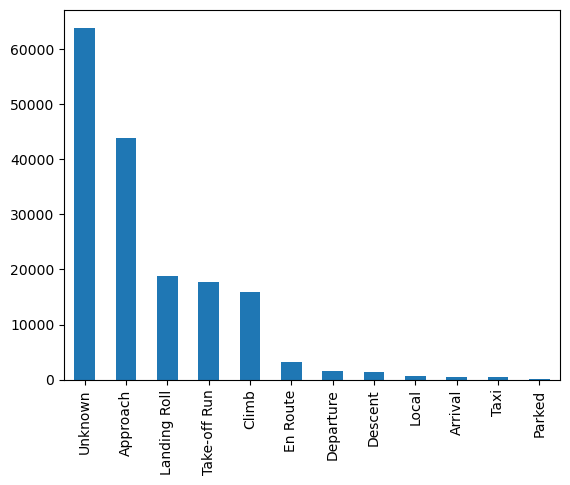


PRECIPITATION
Unknown             89282
None                72160
Rain                 4519
Fog                  1470
Snow                  286
Fog, Rain             198
None, Snow             16
Rain, Snow             13
Fog, Snow               9
Fog, None               4
None, Rain              3
Fog, Rain, Snow         3
None, Rain, Snow        1
Name: precipitation, dtype: int64
Unknown             0.531554
None                0.429616
Rain                0.026905
Fog                 0.008752
Snow                0.001703
Fog, Rain           0.001179
None, Snow          0.000095
Rain, Snow          0.000077
Fog, Snow           0.000054
Fog, None           0.000024
None, Rain          0.000018
Fog, Rain, Snow     0.000018
None, Rain, Snow    0.000006
Name: precipitation, dtype: float64


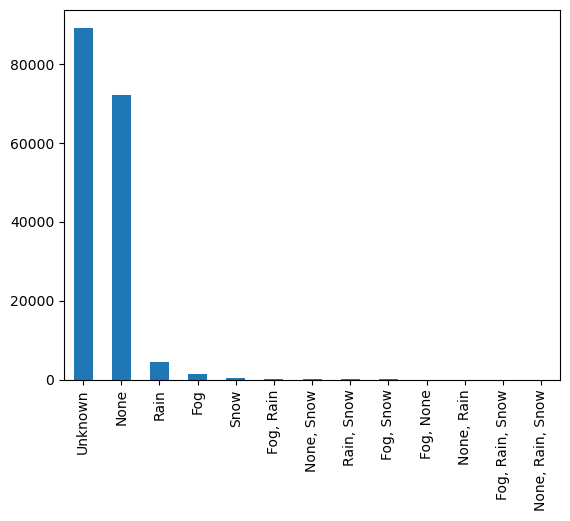


DAMAGE_LEVEL
N    160244
M      5129
S      2542
D        49
Name: damage_level, dtype: int64
N    0.954038
M    0.030536
S    0.015134
D    0.000292
Name: damage_level, dtype: float64


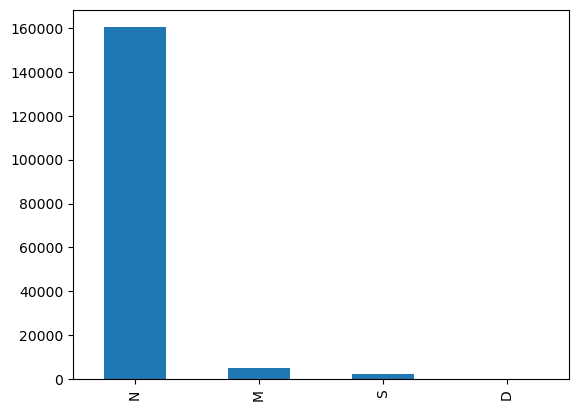


SPECIES_ID
UNKBS     28706
UNKBM     23003
UNKB      13821
O2205      8366
N5111      5465
          ...  
Y9021         1
1E3           1
Z0102         1
ZX326         1
1C1012        1
Name: species_id, Length: 807, dtype: int64
UNKBS     0.170906
UNKBM     0.136952
UNKB      0.082285
O2205     0.049808
N5111     0.032537
            ...   
Y9021     0.000006
1E3       0.000006
Z0102     0.000006
ZX326     0.000006
1C1012    0.000006
Name: species_id, Length: 807, dtype: float64


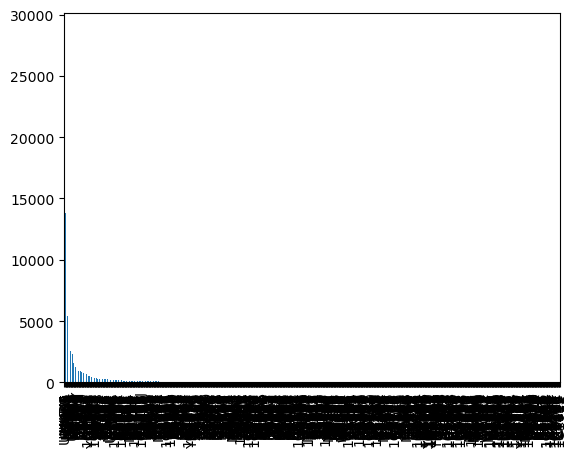


SPECIES
Unknown bird - small     28706
Unknown bird - medium    23003
Unknown bird             13821
Mourning dove             8366
Killdeer                  5465
                         ...  
Common kingsnake             1
Hoary redpoll                1
Gray-headed chickadee        1
Little swift                 1
Indian flying fox            1
Name: species, Length: 811, dtype: int64
Unknown bird - small     0.170906
Unknown bird - medium    0.136952
Unknown bird             0.082285
Mourning dove            0.049808
Killdeer                 0.032537
                           ...   
Common kingsnake         0.000006
Hoary redpoll            0.000006
Gray-headed chickadee    0.000006
Little swift             0.000006
Indian flying fox        0.000006
Name: species, Length: 811, dtype: float64


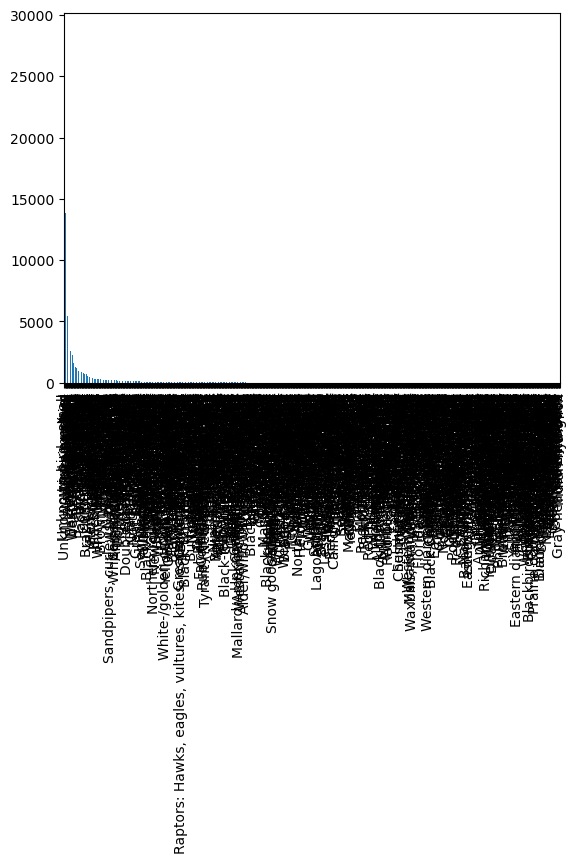


SIZE_OF_SPECIES
Small      103488
Medium      39601
Unknown     14083
Large       10792
Name: size_of_species, dtype: int64
Small      0.616132
Medium     0.235771
Unknown    0.083845
Large      0.064252
Name: size_of_species, dtype: float64


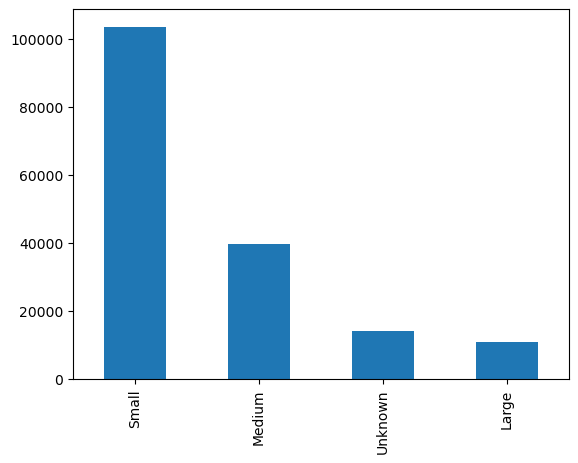

In [12]:
for col in col_cats:
    print (col.upper())
    print (train[col].value_counts())
    print (train[col].value_counts(normalize=True))
    train[col].value_counts().plot.bar()
    plt.show()
    print()

### numeric variables

AC_MASS
4    83837
0    47447
3    20039
2     7682
1     7678
5     1281
Name: ac_mass, dtype: int64


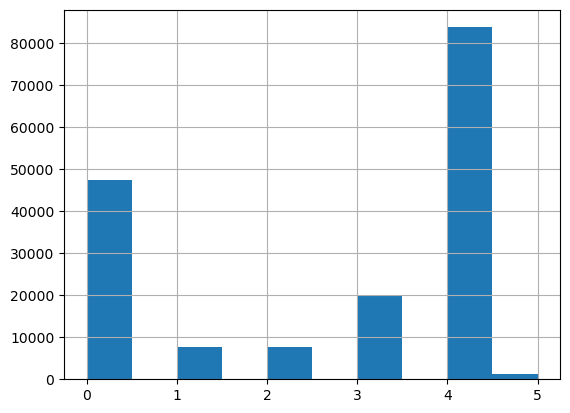


NUM_ENGS
 2    104812
-1     47572
 1      7813
 3      5827
 4      1937
 0         3
Name: num_engs, dtype: int64


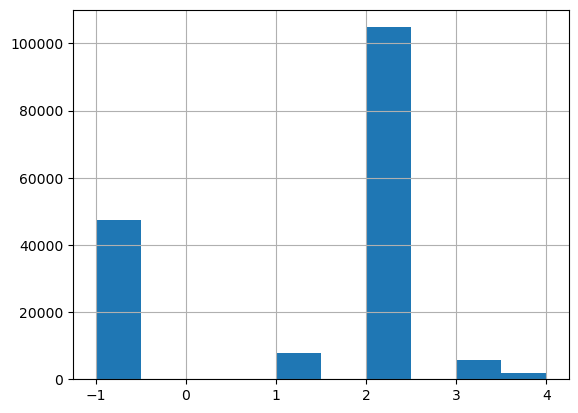


NR_INJURIES
0    167793
1       136
2        31
7         2
3         1
4         1
Name: nr_injuries, dtype: int64


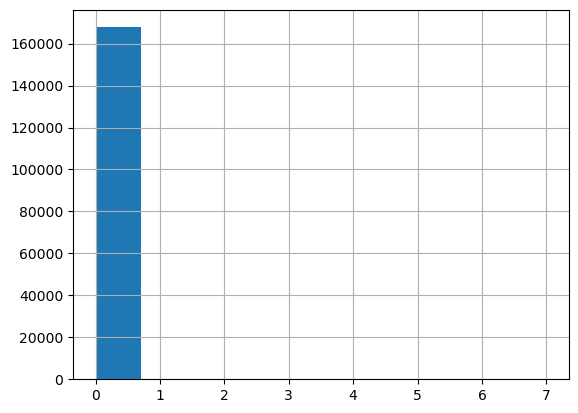


NR_FATALITIES
0    167949
1         9
2         3
3         1
8         1
5         1
Name: nr_fatalities, dtype: int64


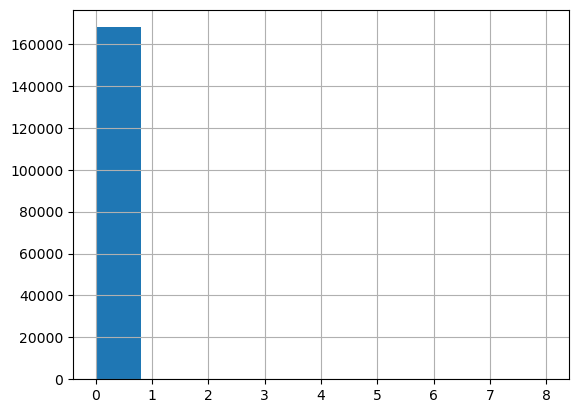

In [13]:
for col in num_cats:
    print(col.upper())
    print(train[col].value_counts())
    train[col].hist()
    plt.show()
    print()

# Takeaways from initial visualization of categorical and continuous variables:
- TARGET: damage_level

- I don't think I should use nr_injuries or nr_fatalities to predict damage_level. Both (all) are things that happen post bird strike. I want predictive variables. 
    - Drop nr_fatalities and nr_injuries for modeling
    

- Top to Bottom:
- date: index, useful for time series analysis later
- time_of_day: 42% unknown, the rest are in order Day, Night, Dusk, Dawn
    - check for association, probably drop
- airport_id: 12% unknown, then >2000 unique entries.  
    - maybe do a separate project to model only the bird strikes at Denver (9260 rows)
    - Drop because it's too many categories. could bin to something maybe
- airport:
    - DROP, repeated info from airport_id
- runway:
    - Probably drop. OR fix (standardize) then check
- state:
    - still a lot of categories
    - could take one or two states and run separate model
    - Drop
- opid:
    - Airline. lots of categories. could narrow to majors + BUS + PRIV + Unknown maybe
- operator:
    - repeated data from opid. Drop
- aircraft
    - probably drop.  ac_class/ac_mass more valuable
- ac_class
- ac_mass
- type_eng
- num_engs
- phase_of_flight: bin into Ground, Runway, Departure, Enroute, Approach, Unknown
- precipitation:
    - check and probably drop
- species_id / species
    - too many unknowns. could plot and see
- size_of_species
    - Keep
    


## Priorities:
1. size_of_species
2. ac_mass
2a. ac_class

3. phase_of_flight, time_of_day

other

## Q1. Hypothesize: Is size_of_species associated with damage_level?

### Visualize

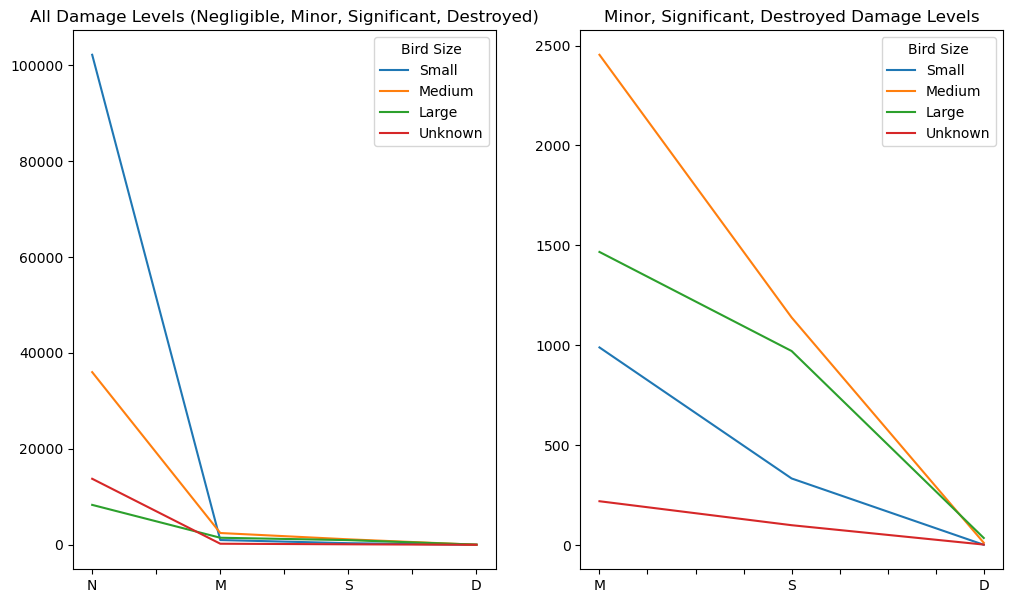

In [48]:
# plot the number of aircraft that received N/M/S/D damage levels vs bird size
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
size_un_values = ['Small', 'Medium', 'Large', 'Unknown']
for v in size_un_values:
    train[train.size_of_species == v].damage_level.value_counts().plot(label=v)
plt.legend(title ='Bird Size')
plt.title('All Damage Levels (Negligible, Minor, Significant, Destroyed)')
# plt.xticks(ticks=['N', 'M', 'S', 'D'], labels=['Negligible', 'Minor', 'Significant', 'Destroyed'])

plt.subplot(1,2,2)
size_un_values = ['Small', 'Medium', 'Large', 'Unknown']
for v in size_un_values:
    train[(train.size_of_species == v) & (train.damage_level != 'N')].damage_level.value_counts().plot(label=v)
plt.legend(title ='Bird Size')
plt.title('Minor, Significant, Destroyed Damage Levels')
# plt.xticks(ticks=['M', 'S', 'D'], labels=['Minor', 'Significant', 'Destroyed'])

plt.show()

### Analyze size_of_species vs damage_level with statistics
- $H_0$ There is NO relationship between size_of_species and damage_level charges
- $H_a$ There IS a relationship
- $\alpha$ = .05
categorical vs categorical => chi^2 test

In [50]:
observed = pd.crosstab(train.size_of_species, train.damage_level)
observed

damage_level,D,M,N,S
size_of_species,,,,
Large,35,1467,8319,971
Medium,11,2454,35997,1139
Small,1,989,102165,333
Unknown,2,219,13763,99


In [60]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, pd.DataFrame(expected.round().astype(int))

(13257.311938713829,
 0.0,
 9,
     0     1      2     3
 0   3   330  10296   163
 1  12  1209  37781   599
 2  30  3160  98731  1566
 3   4   430  13436   213)

### Summarize size_of_species vs damage_level

- p is < .05, so we can reject the null hypothesis which suggests the $H_a$
- In summary, there is an association between size_of_species and damage_level
    * Large birds = Higher Damage Levels
    * Medium birds result in more minor damage, but not destroyed or significant damage
    * Small birds result in less damage

# Question 2: Is ac_mass associated with damage_level?
- Hypothesize/Visualize/Analyze/Summarize

### Visualize

In [73]:
mass_un_values = sorted(train.ac_mass.unique())
mass_un_values

[0, 1, 2, 3, 4, 5]

In [82]:
train.ac_mass.value_counts().sort_index()

0    47447
1     7678
2     7682
3    20039
4    83837
5     1281
Name: ac_mass, dtype: int64

In [86]:
train.ac_mass = train.ac_mass.astype('category')

(array([3., 0., 1., 0., 0., 1., 0., 0., 0., 1.]),
 array([ 1281. ,  9536.6, 17792.2, 26047.8, 34303.4, 42559. , 50814.6,
        59070.2, 67325.8, 75581.4, 83837. ]),
 <BarContainer object of 10 artists>)

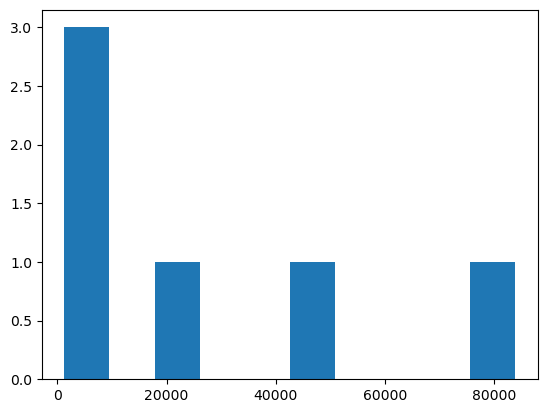

In [101]:
plt.hist(train.ac_mass.value_counts().sort_index())

In [ ]:
sns.histplot(data=train, x=

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167964 entries, 2004-07-02 to 2001-11-04
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   time_of_day      167964 non-null  object
 1   airport_id       167964 non-null  object
 2   airport          167964 non-null  object
 3   runway           167964 non-null  object
 4   state            167964 non-null  object
 5   opid             167964 non-null  object
 6   operator         167964 non-null  object
 7   aircraft         167964 non-null  object
 8   ac_class         167964 non-null  object
 9   ac_mass          167964 non-null  int64 
 10  type_eng         167964 non-null  object
 11  num_engs         167964 non-null  int64 
 12  phase_of_flight  167964 non-null  object
 13  precipitation    167964 non-null  object
 14  damage_level     167964 non-null  object
 15  species_id       167964 non-null  object
 16  species          167964 non-null  object

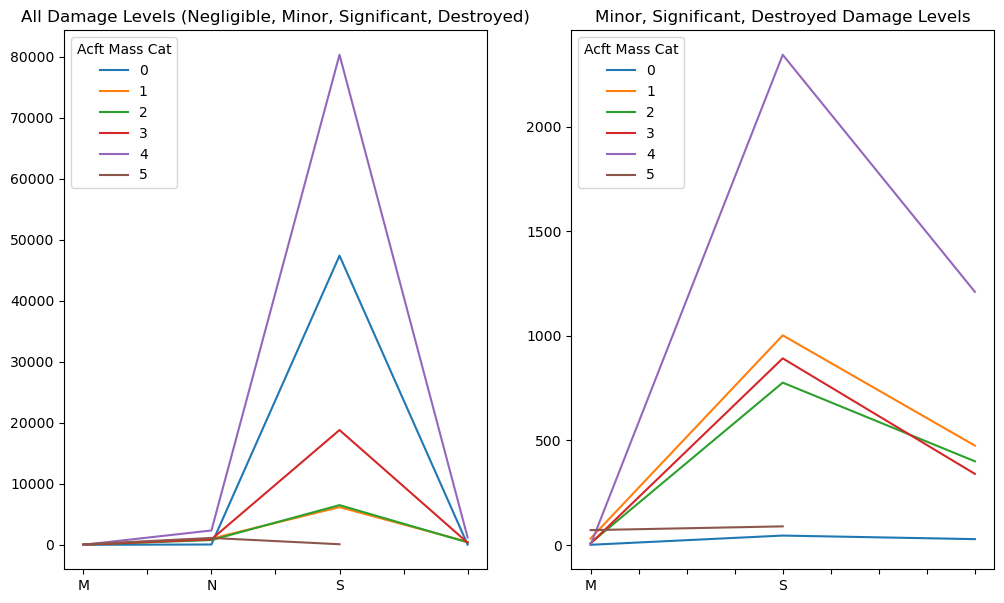

In [84]:
# plot the number of aircraft that received N/M/S/D damage levels vs ac_mass
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
mass_un_values = sorted(train.ac_mass.unique())
for v in mass_un_values:
    train[train.ac_mass == v].damage_level.value_counts().sort_index().plot(label=v)
plt.legend(title ='Acft Mass Cat')
plt.title('All Damage Levels (Negligible, Minor, Significant, Destroyed)')
# plt.xticks(ticks=['N', 'M', 'S', 'D'], labels=['Negligible', 'Minor', 'Significant', 'Destroyed'])

plt.subplot(1,2,2)
mass_un_values = sorted(train.ac_mass.unique())
for v in mass_un_values:
    train[(train.ac_mass == v) & (train.damage_level != 'N')].damage_level.value_counts().sort_index().plot(label=v)
plt.legend(title ='Acft Mass Cat')
plt.title('Minor, Significant, Destroyed Damage Levels')
# plt.xticks(ticks=['M', 'S', 'D'], labels=['Minor', 'Significant', 'Destroyed'])

plt.show()

### Analyze ac_mass vs damage_level with statistics
- $H_0$ There is NO relationship between ac_mass and damage_level charges
- $H_a$ There IS a relationship
- $\alpha$ = .05
categorical vs categorical => chi^2 test